In [1]:
import csv
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib.pyplot as plt

import numpy as np
formatter = {'float': '{: 0.2f}'.format, 'int': '{: 0.2f}'.format}
formatter8 = {'float': '{: 0.8f}'.format, 'int': '{: 0.2f}'.format}

import time
import datetime
import random

In [2]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def d_sigmoid(x):
    s = sigmoid(x)
    return  s * (1 - s)


def ReLU(x):
    return x if x > 0 else 0

def d_ReLU(x):
    return 1 if x > 0 else 0


def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 / np.cosh(x) ** 2


def linear(x):
    return x

def d_linear(x):
    return 1

def print_red(text, end='\n'): print("\033[91m {}\033[00m" .format(text), end=end)
def print_green(text, end='\n'): print("\033[92m {}\033[00m" .format(text), end=end)
def print_yellow(text, end='\n'): print("\033[93m {}\033[00m" .format(text), end=end)
def print_light_purple(text, end='\n'): print("\033[94m {}\033[00m" .format(text), end=end)
def print_purple(text, end='\n'): print("\033[95m {}\033[00m" .format(text), end=end)
def print_cyan(text, end='\n'): print("\033[96m {}\033[00m" .format(text), end=end)
def print_light_gray(text, end='\n'): print("\033[97m {}\033[00m" .format(text), end=end)
def print_black(text, end='\n'): print("\033[98m {}\033[00m" .format(text), end=end)

def progress(start, percent=0, width=50):
    time_elapsed = time.time() - start
    time_left = time_elapsed / percent - time_elapsed if percent > 0 else 0
    time_left_str_arr = str(datetime.timedelta(seconds=time_left)).split(':')
    time_left_str_arr[2] = format(float(time_left_str_arr[2]), '.0f')
    time_left_str = ':'.join(time_left_str_arr)
    left = math.floor(width * percent)
    right = width - left
    tags = "#" * left
    spaces = " " * right
    percentage_str = str(format(float(percent) * 100.0, '.4f'))
    print("\rLoading ::: [" + str(tags) + str(spaces) + "]" + percentage_str + "% ::: " + time_left_str, end="")
    if percent == 1:
        print()

In [3]:
def get_Weights_Biases(weights_file, biases_file):
    imported_weights = []
    imported_biases = []
    with open(weights_file, 'r') as f:
        csvreader = csv.reader(f)
        imported_weights = [[] for _ in range(0, 3)]
        index = 0
        for row in csvreader:
            if len(row) == 0:
                index += 1
            else:
                imported_weights[index].append([float(x) for x in row])

    with open(biases_file, 'r') as f:
        csvreader = csv.reader(f)
        imported_biases = [[] for _ in range(0, 3)]
        index = 0
        for row in csvreader:
            if len(row) == 0:
                index += 1
            else:
                imported_biases[index].append([float(x) for x in row])

    return imported_weights, imported_biases

training_data = []
with open('mnist_train.csv', 'r') as f:
    reader = csv.reader(f)
    training_data = list(reader)

training_data_seperated = {}
for row in training_data[1:]:
    label = row[0]
    if label not in training_data_seperated:
        training_data_seperated[label] = []
    training_data_seperated[label].append([int(x) for x in row[1:]])

testing_data_str = []
with open('mnist_test.csv', 'r') as f:
    reader = csv.reader(f)
    testing_data_str = list(reader)

testing_data = []
for row in testing_data_str[1:]:
    testing_data.append([int(x) for x in row[1:]])

In [5]:
class NeuralNetwork:

    def __init__(self, input_shape, hidden_heights, Y_shape, 
                 learning_rate = 1, activation_function = sigmoid, activation_derivative = d_sigmoid):

        self.num_layers = 1 + len(hidden_heights) + 1
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative

        self.Weights = [0 for _ in range(0, self.num_layers - 1)]
        self.Biases  = [0 for _ in range(0, self.num_layers - 1)]

        left_shape = input_shape
        for layer in range(0, len(hidden_heights)):
            right_shape = hidden_heights[layer]
            self.Weights[layer] = np.random.randn(right_shape, left_shape)
            self.Biases[layer] = np.random.randn(right_shape, 1)
            left_shape = right_shape
        right_shape = Y_shape
        self.Weights[len(hidden_heights)] = np.random.randn(right_shape, left_shape)
        self.Biases[len(hidden_heights)] = np.random.randn(right_shape, 1)


    def set_data(self, Weights, Biases):
        self.Weights = Weights
        self.Biases = Biases


    def create_data(self, input_cases):
        A_groups = []
        for input_case in input_cases:
            A = [0 for _ in range(0, self.num_layers)]
            A[0] = np.array([input_case]).T
            A_groups.append(A)
        return A_groups

    
    def export_data(self, weight_file, bias_file):
        with open(weight_file, 'w') as f:
            csvwriter = csv.writer(f)
            for weight in self.Weights:
                csvwriter.writerows(weight)
                csvwriter.writerow([])

        with open(bias_file, 'w') as f:
            csvwriter = csv.writer(f)
            for bias in self.Biases:
                csvwriter.writerows(bias)
                csvwriter.writerow([])

    def train(self, input_cases, Y_groups, tol, max_iterations, get_plot = False): 
        A_groups = self.create_data(input_cases)
        A_groups, Z_groups = self.forward_prop(A_groups)
        C = 100
        count = 0
        x_vals = []
        y_vals = []
        start = time.time()
        while C > tol and count < max_iterations:
            progress(start, count / max_iterations) 
            A_groups, Z_groups, C = self.backward_prop(A_groups, Z_groups, Y_groups)
            A_groups, Z_groups = self.forward_prop(A_groups)
            count += 1
            x_vals.append(count)
            y_vals.append(np.log10(C))
        while count <= max_iterations:
            progress(start, count / max_iterations)
            count += 1
            
        fig = None
        if get_plot:
            fig = plt.figure()
            plt.plot(x_vals, y_vals)
            plt.xlabel('Iterations')
            plt.ylabel(r'$\log{}$(Cost)')
            plt.title('Cost per Iterations' + ' (' + str(len(input_cases)) + ' test cases)')
            plt.grid(True)
        return C, fig


    def test(self, input_cases):
        A_groups = self.create_data(input_cases)
        A_groups, Z_groups = self.forward_prop(A_groups)
        return A_groups


    def print_results(self, A_groups, Y_groups, print_status, print_plot = False):
        count = 0
        last_layer = len(A_groups[0]) - 1
        for test_case_index in range(0, len(A_groups)):
            test_input = np.around(A_groups[test_case_index][0].T, decimals=2)
            rounded_result = np.around(A_groups[test_case_index][last_layer], decimals=0).T
            test_status = 'PASS' if False not in (rounded_result == Y_groups[test_case_index].T) else 'FAIL'
            count += 1 if test_status == 'PASS' else 0

            if print_status:
                if test_status == 'PASS':
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_green(str(test_input), end=" : ")
                        print_green(str(rounded_result), end=" : ")
                    print_green(test_status, end=" : ")
                    with np.printoptions(formatter=formatter8, suppress=True):
                        print_green(str(A_groups[test_case_index][last_layer].T), end=' : ')
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_green(str(np.array(Y_groups[test_case_index]).T), end='\n')
                else:
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_red(str(test_input), end=" : ")
                        print_red(str(rounded_result), end=" : ")
                    print_red(test_status, end=" : ")
                    with np.printoptions(formatter=formatter8, suppress=True):
                        print_red(str(A_groups[test_case_index][last_layer].T), end=' : ')
                    with np.printoptions(formatter=formatter, suppress=True):
                        print_red(str(np.array(Y_groups[test_case_index]).T), end='\n')
        if print_plot:
            plt.show()

        print('PASSED: ', count, '/', len(A_groups), ' - ', format(100 * count / len(A_groups), '.4f'), '%')


    def forward_prop(self, A_groups):
        Z_groups = []
        for A in A_groups:
            Z = [0 for _ in range(0, self.num_layers - 1)]
            for layer in range(0, len(A) - 1):
                Z[layer] = np.dot(self.Weights[layer], A[layer]) + self.Biases[layer]
                A[layer + 1] = self.activation_function(Z[layer])
            Z_groups.append(Z) 
        return A_groups, Z_groups


    def backward_prop(self, A_groups, Z_groups, Y_groups):
        for layer in range(0, self.num_layers - 1):
            DCDW = 0
            DCDB = 0
            for test_case_index in range(0, len(A_groups)):
                A = A_groups[test_case_index]
                Y = Y_groups[test_case_index]
                Z = Z_groups[test_case_index]

                dzdw = A[layer]
                dzdb = np.array([[1]])
                dadz = self.activation_derivative(Z[layer])
                dcda = self.calc_dCda(A, Z, Y, layer + 1)

                dcdw = np.dot(dadz * dcda, dzdw.T)
                dcdb = np.dot(dadz * dcda, dzdb.T)
                DCDW += self.learning_rate * dcdw
                DCDB += self.learning_rate * dcdb
            self.Weights[layer] -= DCDW / len(A_groups)
            self.Biases[layer] -= DCDB / len(A_groups)

        C = 0
        for test_case_index in range(0, len(A_groups)):
            A = A_groups[test_case_index]
            Y = Y_groups[test_case_index]
            C += np.sum((A[self.num_layers - 1] - Y) ** 2)
        C /= len(A_groups)

        return A_groups, Z_groups, C

    
    def calc_dCda(self, A, Z, Y, layer):
        if layer == self.num_layers - 1:
            return 2 * (A[layer] - Y)
        else:
            dzda = self.Weights[layer].T
            dadz = self.activation_derivative(Z[layer])
            return np.dot(dzda, dadz * self.calc_dCda(A, Z, Y, layer + 1))


In [ ]:
floor_NN = NeuralNetwork(input_shape=1, hidden_heights=[3] ,Y_shape=3)

def create_output_data(test_cases):
    Y_groups = []
    for test_case in test_cases:
        Y = np.array([[0, 0, 0]]).T
        Y[math.floor(test_case[0])] = 1
        Y_groups.append(Y)
    return Y_groups


for test in [(3, 5e-5, True), (12, 5e-4, True), (100, 1e-2, False)]:
    test_case = np.linspace(0, 3, test[0], endpoint=False)
    input_data = []
    for case in test_case:
        input_data.append([case])
    Y_groups = create_output_data(input_data)

    C, fig = floor_NN.train(input_data, Y_groups, test[1], 200_000, test[2])
    print('C: ', format(C, '.15f'))

    A_groups = floor_NN.test(input_data)
    floor_NN.print_results(A_groups, Y_groups, print_status=test[2], print_plot=test[2])
    print()

test_case = np.linspace(0, 3, 1000, endpoint=False)
input_data = []
for case in test_case:
    input_data.append([case])
Y_groups = create_output_data(input_data)

A_groups = floor_NN.test(input_data)
floor_NN.print_results(A_groups, Y_groups, print_status=False)
print()


In [ ]:
num_ones_NN = NeuralNetwork(input_shape=3, hidden_heights=[3, 5] ,Y_shape=4)

def create_output_data(test_cases):
    Y_groups = []
    for test_case in test_cases:
        num_ones = int(np.round(np.sum(test_case)))
        Y = np.array([[0, 0, 0, 0]]).T
        Y[num_ones][0] = 1
        Y_groups.append(Y)
    return Y_groups

all_test_cases = [[[0, 0, 0], 
                   [1, 0, 0], [0, 1, 0], [0, 0, 1], 
                   [1 , 1, 0], [0, 1, 1], [1, 0, 1], 
                   [1, 1, 1]], 
                  [np.random.uniform(0, 3.5 / 3, 3) for _ in range(0, 100)]]
test_params = [(5e-3, 200_000, True), (5e-2, 200_000, False), (100, 1e-2, False)]
for test_cases_index in range(0, len(all_test_cases)):
    test_cases = all_test_cases[test_cases_index]
    test_param = test_params[test_cases_index]

    Y_groups = create_output_data(test_cases)
    C, fig = num_ones_NN.train(test_cases, Y_groups, test_param[0], test_param[1], test_param[2])
    print('C: ', format(C, '.15f'))
    A_groups = num_ones_NN.test(test_cases)
    num_ones_NN.print_results(A_groups, Y_groups, print_status=test_param[2], print_plot=test_param[2])
    print()


test_cases = [np.random.uniform(0, 3.5 / 3, 3) for _ in range(0, 15)]
Y_groups = create_output_data(test_cases)
A_groups = num_ones_NN.test(test_cases)
num_ones_NN.print_results(A_groups, Y_groups, print_status=True)
print()


Loading ::: [##################################################]100.0000% ::: 0:00:0
C:  2.890036531334097
PASSED:  21 / 54210  -  0.0387 %


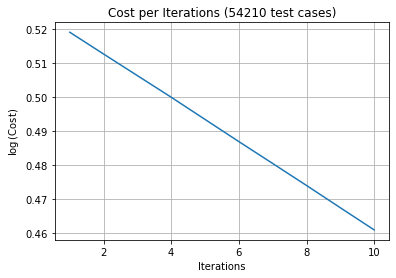

In [11]:
def get_training_set():
    min_len_group = 100_000
    for label in training_data_seperated:
        if len(training_data_seperated[label]) < min_len_group:
            min_len_group = len(training_data_seperated[label])

    test_ans = []
    for label in training_data_seperated:
        curr_case = training_data_seperated[label][0 : min_len_group]
        Y = np.array([[0 for _ in range(0, 10)]]).T
        Y[int(label)][0] = 1
        for case in curr_case:
            test_ans.append((case, Y))

    random.shuffle(test_ans)
    test_cases = [x[0] for x in test_ans]
    Y_groups = [x[1] for x in test_ans]
    return test_cases, Y_groups

test_cases, Y_groups = get_training_set()
num_recog_NN = NeuralNetwork(input_shape=784, hidden_heights=[16] ,Y_shape=10, learning_rate=.05)
C, fig = num_recog_NN.train(test_cases, Y_groups, tol=5e-4, max_iterations=10, get_plot=True)
print('C: ', format(C, '.15f'))
A_groups = num_recog_NN.test(test_cases)
num_recog_NN.print_results(A_groups, Y_groups, print_status=False, print_plot=False)

num_recog_NN.export_data('Number_Recog_Weights.csv', 'Number_Recog_Biases.csv')


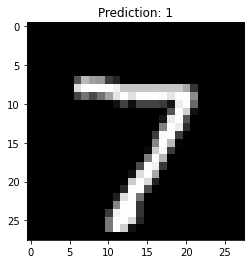

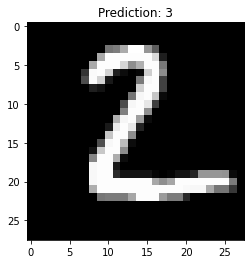

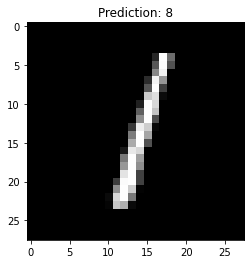

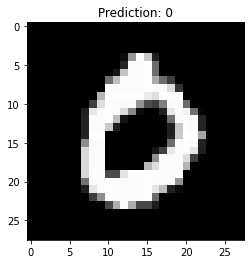

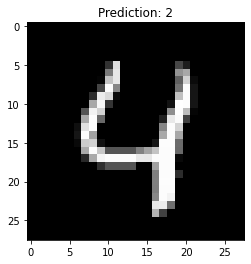

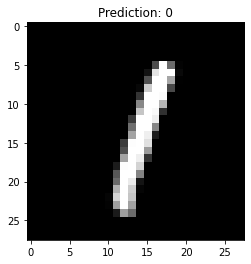

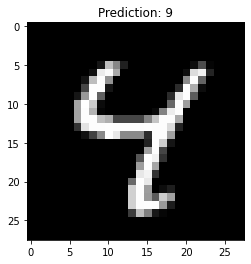

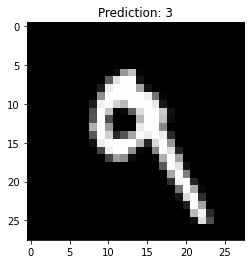

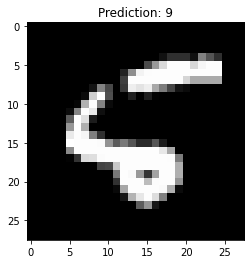

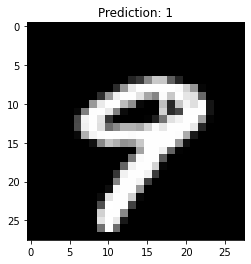

In [9]:
test_cases = testing_data[0: 10]
A_groups = num_recog_NN.test(test_cases)
for test_case_index in range(0, len(A_groups)):
    prediction = np.argmax(A_groups[test_case_index][2])
    plt.figure()
    plt.imshow(np.array(test_cases[test_case_index]).reshape(28, 28), cmap='gray')
    plt.title('Prediction: ' + str(prediction))